In [ ]:
# ===========================================================================
# DIANI Mamoudou Sékou
#
# Aout 2023
#===========================================================================

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import wfdb
import ast
from scipy import stats
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Add, MaxPooling1D, Input, BatchNormalization, UpSampling2D, Activation, Dropout, Flatten, Dense, Lambda, Concatenate, GlobalAveragePooling1D
from keras import backend
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from math import sqrt
from keras.models import load_model
from keras import Model

# Importation des bibliothèques nécessaires pour le traitement d'images avec TensorFlow et Keras
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
from keras.preprocessing.image import ImageDataGenerator

# Utilisation du module XLA pour accelerer les calculs
from tensorflow._api.v2.compat.v1 import xl

In [ ]:
# Cette fonction charge les données brutes à partir des fichiers ECG en utilisant la bibliothèque wfdb.
# Elle prend en parametre le dataFrame contenant les informations sur les fichiers, le taux d'échantillonnage des signaux
# Le chemin vers le répertoire contenant les fichiers et renvoie un tableau contenant les signaux bruts.
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Chemin vers le répertoire contenant les fichiers
path = '/Users/mamoudousdiani/Documents/UQAM/projet_master/Base_de_donnee/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# Taux d'échantillonnage
sampling_rate=100

# Chargement et convertion des données d'annotation
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# # Chargement des données brutes des signaux
X = load_raw_data(Y, sampling_rate, path)

# Chargement de scp_statements.csv pour l'agrégation diagnostique
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


# Cette fonction agrège les diagnostics en utilisant le fichier scp_statements.csv
# Elle prend comme parametre un dictionnaire contenant les codes de diagnostic
# Et renvoie la liste des classes diagnostiques agrégées
# La fonction parcourt les clés du dictionnaire (y_dic) et vérifie si chaque 
# clé existe dans le fichier scp_statements.csv (représenté par le DataFrame agg_df).
# Si la clé existe, la fonction ajoute la classe diagnostique correspondante à la liste temporaire.
# Enfin, la fonction utilise un ensemble (set) pour éliminer les doublons, puis convertit cet ensemble en liste et la renvoie.
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Appliquation de la superclasse diagnostique
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Séparation des données en ensembles d'entraînement, de validation et de test
test_fold = 9
# Train
X_train1 = X[np.where(Y.strat_fold < test_fold)]
y_train1 = Y[(Y.strat_fold < test_fold)].diagnostic_superclass
# validation
X_val1 = X[np.where(Y.strat_fold == test_fold)]
y_val1 = Y[Y.strat_fold == test_fold].diagnostic_superclass
# Test
X_test1 = X[np.where(Y.strat_fold > test_fold)]
y_test1 = Y[Y.strat_fold > test_fold].diagnostic_superclass


In [ ]:
# Cette fonction convertit les codes de diagnostic en un tableau de classe diagnostique.
# Elle prend en paramètre X un dictionnaire contenant les codes de diagnostic pour un enregistrement ECG
# et renvoie un Tableau de classe diagnostique encodé, la liste des indices des diagnostics valides.
# et la liste des indices des diagnostics non valides
def convY(x):
    a=x.keys()
    d=[]
    listeV=[]
    listeNV=[]
    lv=0
    N=0
    M=0
    S=0
    C=0
    H=0
    bof=0
    for i in range(len(a)):
        if 'NORM' in x[a[i]]:
            d.append([1, 0, 0, 0, 0])
            #listeV.append(i)
            N=N+1
        elif 'MI' in x[a[i]]:
            d.append([0, 1, 0, 0, 0])
            listeV.append(i)
            M=M+1
        elif 'STTC' in x[a[i]]:
            d.append([0, 0, 1, 0, 0])
            listeV.append(i)
            S=S+1
        elif 'CD' in x[a[i]]:
            d.append([0, 0, 0, 1, 0])
            listeV.append(i)
            C=C+1
        elif 'HYP' in x[a[i]]:
            d.append([0, 0, 0, 0, 1])
            listeV.append(i)
            H=H+1
        else:
            d.append([0, 0, 0, 0, 0])
            listeNV.append(i)
            bof=bof+1
        lv=lv+1

    d= np.array(d)
    print(N,M,S,C,H,bof)
    return d, listeV, listeNV


# Cette fonction calcule la moyenne et l'écart type des valeurs dans une liste tridimensionnelle
# Elle prend en paramètre une liste tridimensionnelle contenant les valeurs
# Elle retourne la moyenne et l'ecart type des valeurs
def calcul(X_train):
    a=0
    nb=0
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            for k in range(len(X_train[i][j])):
                a=a+X_train[i][j][k]
                nb=nb+1
    moy=a/nb
    b=0
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            for k in range(len(X_train[i][j])):
                b=b+((X_train[i][j][k]-moy)**2)
    ecT=sqrt(b/nb)
    return moy, ecT


# Cette fonction normalise une liste tridimensionnelle en utilisant la moyenne et l'écart type.
# Elle prend en paramètre une liste tridimensionnelle à normaliser, la moyenne des valeurs utilisée pour la normalisation
# l'ecart type des valeurs utilisé pour la normalisation.
# Elle retourne une liste tridimensionnelle normalisée.
def normalisation(l,moy, ecT):
    for i in range(len(l)):
        for j in range(len(l[i])):
            for k in range(len(l[i][j])):
                l[i][j][k] = (l[i][j][k]-moy)/(ecT)
    return l


# Cette fonction supprime les éléments non valides (pas de classe) d'une liste 
# en utilisant la liste des indices des diagnostics non valides.
# Elle prend en paramètre X_train et y_train les listes de signaux et de leures classes 
# lnv la liste contenant les indices des éléments non valides
# Elle retourne les liste contenant les éléments valides correspondant aux indices fournis
def dataConcr(X_train, y_train, lnv):
    dataX=[]
    dataY=[]
    for i in range(len (X_train)):
        if i not in lnv:
            dataX.append(X_train[i])
            dataY.append(y_train[i])

    return (stats.zscore(np.array(dataX)), np.array(dataY))

In [ ]:
# Convertir les labels de la classe en vecteurs binaires
y_train, lv_train, lnv_train = convY(y_train1)
y_val, lv_val, lnv_val=convY(y_val1)
y_test, lv_test, lnv_test=convY(y_test1)

# Traitement des données d'entraînement
X_train, y_train=dataConcr(X_train1, y_train, lnv_train)
X_val, y_val=dataConcr(X_val1, y_val, lnv_val)
X_test, y_test=dataConcr(X_test1, y_test, lnv_test)

In [ ]:
# Calculer la forme des données d'entrée
dataShape = (len(X_train[0]), len(X_train[0][0]))
# Créer un objet d'entrée pour le modèle avec la forme calculée
img_input = Input(shape=dataShape)

In [ ]:

# Création d'une architecture basée sur VGG16
# pour l'extraction des caractéristiques à partir de séquences temporelles 1D.
def feature_extraction(input):
    x = Conv1D(64, 3, padding= "same")(input)
    x = Activation("relu")(x)
    x = Conv1D(64, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(128, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(256, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(256, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = Conv1D(512, 3, padding= "same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling1D(pool_size=2)(x)# L'ensemble des features/caract ristiques extraits
    return encoded

# Partie completement connectee (Fully Connected Layer) pour la classification multiclasse.
def fully_connected(encoded):
    x = Flatten()(encoded)
    x = Dense(4096)(x)
    x = Activation("relu")(x)

    x = Dense(4096)(x)
    x = Activation("relu")(x)
    x = Dense(5)(x)
    sortie = Activation('sigmoid')(x)
    return sortie

# Declaration du modele:
model = Model(img_input, fully_connected(feature_extraction(img_input)))

# Affichage des parametres du modele
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 64)          2368      
                                                                 
 activation (Activation)     (None, 1000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 64)          12352     
                                                                 
 activation_1 (Activation)   (None, 1000, 64)          0         
                                                                 
 batch_normalization (BatchN  (None, 1000, 64)         256       
 ormalization)                                                   
                                                             

Epoch 1/70
95/95 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6023
Epoch 1: val_accuracy improved from -inf to 0.33691, saving model to Model.hdf5
95/95 [==============================] - 138s 1s/step - loss: 0.7291 - accuracy: 0.6023 - val_loss: 0.4780 - val_accuracy: 0.3369
Epoch 2/70
95/95 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.7235
Epoch 2: val_accuracy improved from 0.33691 to 0.51118, saving model to Model.hdf5
95/95 [==============================] - 143s 2s/step - loss: 0.2630 - accuracy: 0.7235 - val_loss: 0.4906 - val_accuracy: 0.5112
Epoch 3/70
95/95 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.7588
Epoch 3: val_accuracy improved from 0.51118 to 0.55871, saving model to Model.hdf5
95/95 [==============================] - 143s 2s/step - loss: 0.2326 - accuracy: 0.7588 - val_loss: 0.4376 - val_accuracy: 0.5587
Epoch 4/70
95/95 [==============================] - ETA: 0s - loss: 0.2109 - accur

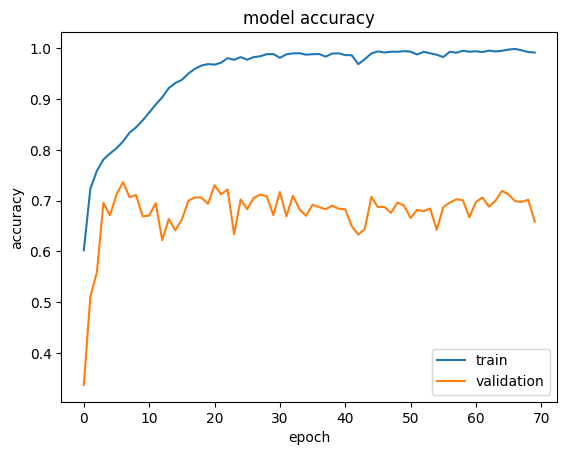

In [ ]:
# Compilation du modele en definissant la fonction de perte, l'optimisateur et la valeur afficher durant l'entrainement
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Sauvegarde du modèle ayant le meilleur val_accuracy pendant l'entraînement dans Model.hdf5. 
modelsPath = "Model.hdf5"
modelcheckpoint = ModelCheckpoint(filepath=modelsPath,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# entrainement du modele
classifier = model.fit(X_train, y_train,
                       epochs=70, # nombre d' poques
                       batch_size=180, # nombre d'images entrain es ensemble
                       validation_data=(X_val, y_val), # donn es de validation
                       verbose=1, # mets cette valeur   0, si vous voulez ne pas afficher les d tails d'entrainement
                       callbacks=[modelcheckpoint], # les fonctions   appeler   la fin de chaque  poque (dans ce cas modelcheckpoint: qui sauvegarde le mod le)
                       shuffle=True)# shuffle les images

# ==========================================
# ========AFFICHAGE DES RESULTATS===========
# ==========================================

# Plot accuracy over epochs (precision par  poque)
print(classifier.history.keys())
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
fig = plt.gcf()
plt.show()


In [ ]:
# Chargement du modèle à partir du fichier spécifié.
model_path = "Model.hdf5"
Classifier : Model = load_model(model_path)


#Utilisation du modèle pour effectuer des prédictions sur l'ensemble de test 
# et Arrondissement des prédictions à la classe la plus probable (0 ou 1 dans le cas d'une classification binaire).
predicted_classes = Classifier.predict(X_test)
predicted_classes = np.round(predicted_classes)

#Calcul et affichage des métriques de performance 
acc=accuracy_score(y_test, predicted_classes)
precision=precision_score(y_test, predicted_classes, average='micro')
recall=recall_score(y_test, predicted_classes, average='micro')
f1=f1_score(y_test, predicted_classes, average='micro')
t=0
f=0
for i in range(len(predicted_classes)):

    if  False in (y_test[i]==predicted_classes[i]):
        f=f+1
    else:
        t=t+1

print("Acc=",acc)
print("precision=",precision)
print("recall=",recall)
print("f1=",f1)
print("************************")
print ((t/len(y_test))*100)
print("**********")
print ((f/len(y_test))*100)


# Cette fonction renvoie les indices des échantillons bien classés pour chaque classe.
# Elle prend en parametre x la liste des classes des donnees de test
# Elle retourne les listes des indices de chaque classe.
def nbMalVal(x):
    Norm=[]
    Mi=[]
    Sttc=[]
    Cd=[]
    Hyp=[]
    for i in range(len(x)):
        if x[i][0]==1:
            Norm.append(i)
        elif x[i][1]==1:
            Mi.append(i)
        elif x[i][2]==1:
            Sttc.append(i)
        elif x[i][3]==1:
            Cd.append(i)
        elif x[i][4]==1:
            Hyp.append(i)

    return Norm, Mi, Sttc, Cd, Hyp


# Cette fonction calcule le pourcentage de prédictions correctes et incorrectes pour une classe donnée.
# Elle prend en parametre Norm la liste d'indice d'une classes .
# Elle retourne le pourcentages de prédictions correctes et incorrectes.
def resultPrct(Norm):
  t=0
  f=0
  for i in range(len(Norm)):
    if  False in (y_test[Norm[i]]==predicted_classes[Norm[i]]):
        f=f+1
    else:
        t=t+1
  true = ((t/len(Norm))*100)
  false= ((f/len(Norm))*100)
  return true, false


# Affichage du pourcentage de prédictions correctes (true) et incorrectes (false) pour chaque classe.
Norm, Mi, Sttc, Cd, Hyp=nbMalVal(y_test)
Nt, Nf = resultPrct(Norm)
Mt, Mf = resultPrct(Mi)
St, Sf = resultPrct(Sttc)
Ct, Cf = resultPrct(Cd)
Ht, Hf = resultPrct(Hyp)
print(Nt, Nf, Mt, Mf, St, Sf, Ct, Cf, Ht,Hf)


68/68 [==============================] - 3s 22ms/step
Acc= 0.6756255792400371
precision= 0.7363134103465595
recall= 0.6793327154772938
f1= 0.7066763075439865
************************
67.56255792400371
**********
32.437442075996294
79.64693665628245 20.35306334371755 73.81818181818181 26.181818181818183 56.34920634920635 43.65079365079365 34.12322274881517 65.87677725118483 0.0 100.0
